In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from pathlib import Path
from torch import nn
import helper_functions
import os
from PIL import Image

/home/shiba/Projects/Academics/Nail Disease Detection/.env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading the data

In [5]:
from torchvision.datasets import ImageFolder
from torchvision import transforms as T
from torch.utils.data import DataLoader


# Normalization and transforming data into tensors
transform = T.Compose([
    T.Resize(size=(224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

DATA_DIR = Path("data/nail-disease-roboflow")
TEST_DIR = DATA_DIR / "test"
test_data = ImageFolder(root=TEST_DIR,
                        transform=transform,
                        target_transform=None)

class_names = test_data.classes


# Test Dataloader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False)

# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
MODELS_PATH = Path("models")

## VGG16

Documentation: https://docs.pytorch.org/vision/main/models/generated/torchvision.models.vgg16.html

### VGG 16 Architecture

In [4]:
from torchvision import models

vgg16 = models.vgg16()

# Change VGG16 to output 10 classes
vgg16.classifier[6] = nn.Linear(in_features=4096, out_features=len(class_names))
vgg16 = vgg16.to(device)

In [5]:
WEIGHTS_PATH = MODELS_PATH / "vgg_16" / "weights" / "vgg_16_epoch_15.pth"

state_dict = torch.load(f=WEIGHTS_PATH, map_location=device)
vgg16.load_state_dict(state_dict=state_dict)

<All keys matched successfully>

### Evaluating VGG16

In [6]:
y_preds, y_true = helper_functions.make_predictions(model=vgg16,
                                                    test_data=test_data,
                                                    test_dataloader=test_dataloader,
                                                    device=device)

Making predictions: 100%|██████████| 10/10 [01:01<00:00,  6.14s/it]


#### Confusion Matrix

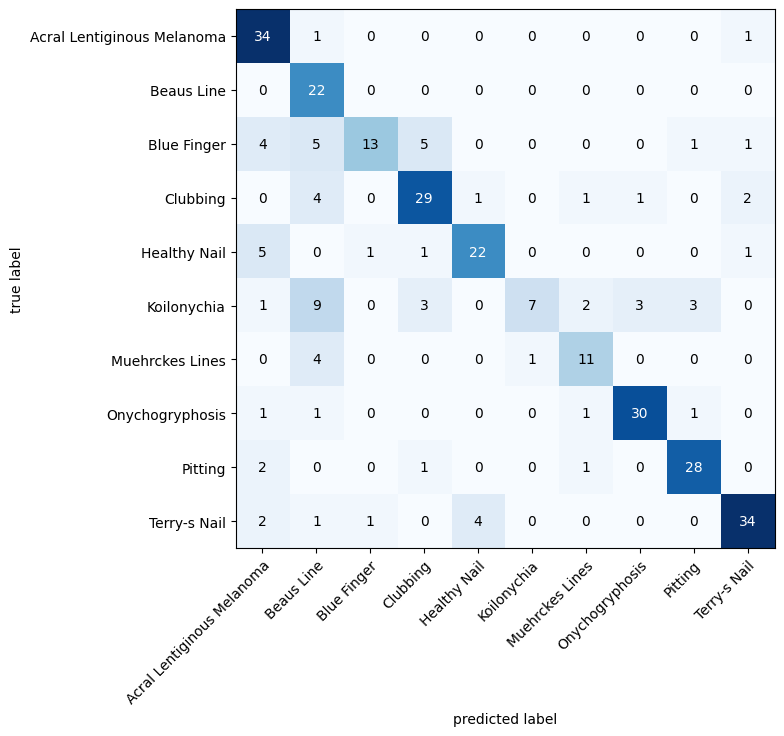

In [7]:
from mlxtend.plotting import plot_confusion_matrix
from torchmetrics import ConfusionMatrix

conf_mat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
conf_mat_tensor = conf_mat(y_preds, y_true)

fig, ax = plot_confusion_matrix(conf_mat=conf_mat_tensor.numpy(), class_names=class_names, figsize=(10,7))

#### Classification Report

In [8]:
from sklearn.metrics import classification_report
report = classification_report(y_preds, y_true, target_names=class_names)
print(report)

                            precision    recall  f1-score   support

Acral Lentiginous Melanoma       0.94      0.69      0.80        49
                Beaus Line       1.00      0.47      0.64        47
               Blue Finger       0.45      0.87      0.59        15
                  Clubbing       0.76      0.74      0.75        39
              Healthy Nail       0.73      0.81      0.77        27
               Koilonychia       0.25      0.88      0.39         8
           Muehrckes Lines       0.69      0.69      0.69        16
           Onychogryphosis       0.88      0.88      0.88        34
                   Pitting       0.88      0.85      0.86        33
              Terry-s Nail       0.81      0.87      0.84        39

                  accuracy                           0.75       307
                 macro avg       0.74      0.78      0.72       307
              weighted avg       0.82      0.75      0.76       307



#### Making a single prediction

Predicted class index: 4
Class probabilities:
Acral Lentiginous Melanoma: 0.00
Beaus Line: 0.00
Blue Finger: 0.00
Clubbing: 0.01
Healthy Nail: 0.98
Koilonychia: 0.00
Muehrckes Lines: 0.00
Onychogryphosis: 0.00
Pitting: 0.00
Terry-s Nail: 0.01


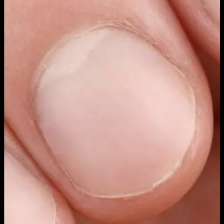

In [9]:
IMAGE_PATH = TEST_DIR / "Healthy Nail" / "105.jpg"

pred_prob, pred_class = helper_functions.make_single_prediction(model=vgg16,
                                                                image_path=IMAGE_PATH,
                                                                transforms=transform,
                                                                device=device)

print(f"Predicted class index: {pred_class}")
print("Class probabilities:")

for i, prob in enumerate(pred_prob):
    print(f"{class_names[i]}: {prob:.2f}")

Image.open(IMAGE_PATH)

## EfficientNetV2S

#### Architecture

In [7]:
from torchvision import models

efficientnet_v2_s = models.efficientnet_v2_s()

# Change the output layer to be 10 classes
efficientnet_v2_s.classifier[1] = nn.Linear(efficientnet_v2_s.classifier[1].in_features, len(class_names))
efficientnet_v2_s = efficientnet_v2_s.to(device)

In [8]:
WEIGHTS_PATH = MODELS_PATH / "efficient_net_v2_s" / "weights" / "efficient_net_v2_s_5.pth"

state_dict = torch.load(f=WEIGHTS_PATH, map_location=device)
efficientnet_v2_s.load_state_dict(state_dict=state_dict)

<All keys matched successfully>

### Evaluating EfficientNetV2S

In [9]:
y_preds, y_true = helper_functions.make_predictions(model=efficientnet_v2_s,
                                                    test_data=test_data,
                                                    test_dataloader=test_dataloader,
                                                    device=device)

Making predictions:   0%|          | 0/10 [00:03<?, ?it/s]


KeyboardInterrupt: 

#### Confusion Matrix

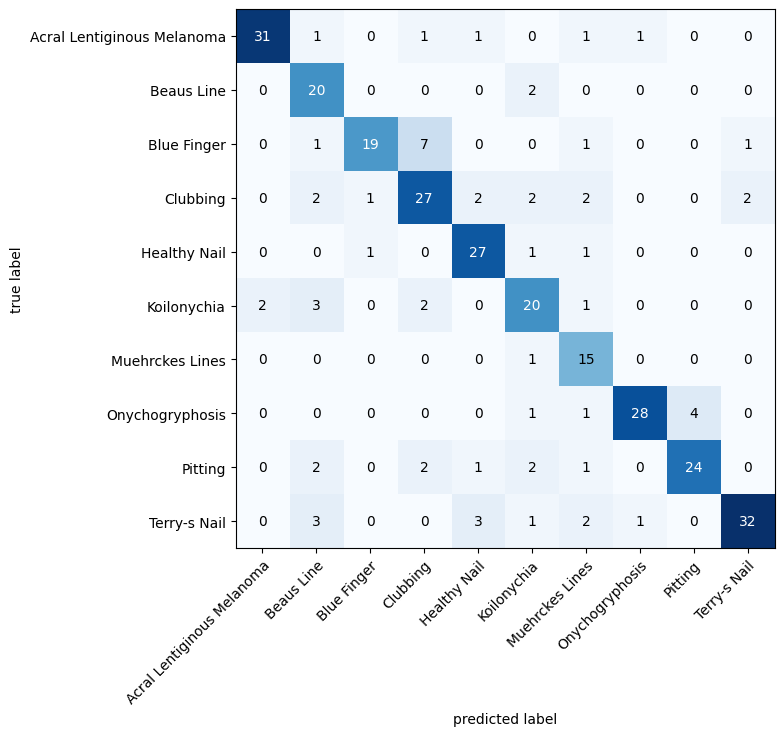

In [7]:
from mlxtend.plotting import plot_confusion_matrix
from torchmetrics import ConfusionMatrix

conf_mat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
conf_mat_tensor = conf_mat(y_preds, y_true)

fig, ax = plot_confusion_matrix(conf_mat=conf_mat_tensor.numpy(), class_names=class_names, figsize=(10,7))

#### Classification Report

In [8]:
from sklearn.metrics import classification_report
report = classification_report(y_preds, y_true, target_names=class_names)
print(report)

                            precision    recall  f1-score   support

Acral Lentiginous Melanoma       0.86      0.94      0.90        33
                Beaus Line       0.91      0.62      0.74        32
               Blue Finger       0.66      0.90      0.76        21
                  Clubbing       0.71      0.69      0.70        39
              Healthy Nail       0.90      0.79      0.84        34
               Koilonychia       0.71      0.67      0.69        30
           Muehrckes Lines       0.94      0.60      0.73        25
           Onychogryphosis       0.82      0.93      0.88        30
                   Pitting       0.75      0.86      0.80        28
              Terry-s Nail       0.76      0.91      0.83        35

                  accuracy                           0.79       307
                 macro avg       0.80      0.79      0.79       307
              weighted avg       0.80      0.79      0.79       307



#### Making a single prediction

Predicted class index: 2
Class probabilities:
Acral Lentiginous Melanoma: 0.03
Beaus Line: 0.25
Blue Finger: 0.58
Clubbing: 0.04
Healthy Nail: 0.01
Koilonychia: 0.01
Muehrckes Lines: 0.07
Onychogryphosis: 0.00
Pitting: 0.00
Terry-s Nail: 0.01


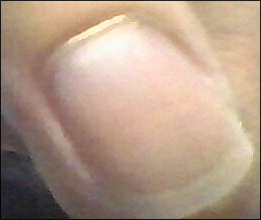

In [ ]:
## IMAGE_PATH = TEST_DIR / "Healthy Nail" / "89.jpg"
IMAGE_PATH = "image.png"

pred_prob, pred_class = helper_functions.make_single_prediction(model=efficientnet_v2_s,
                                                                image_path=IMAGE_PATH,
                                                                transforms=transform,
                                                                device=device)

print(f"Predicted class index: {pred_class}")
print("Class probabilities:")

for i, prob in enumerate(pred_prob):
    print(f"{class_names[i]}: {prob:.2f}")

Image.open(IMAGE_PATH)